## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [40]:
#undistort camera
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

def calibrate_camera():
    imgs = glob.glob('./camera_cal/*.jpg')
    objpoints = []
    imgpoints = []
    for img in imgs:
        img = cv2.imread(img)
        objp = np.zeros((6*9, 3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = calibrate_camera()

In [41]:
def distortion_correction(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def abs_sobel_thresh(img, orient='x', thresh=(20,100), sobel_kernel=3):
    thresh_min, thresh_max, = thresh
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) #We apply the sobel operator to the gray image
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel) # We get the absolute value of the image
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # we convert the absolute value to an 8-bit image
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 # we filter out parts of the image not within the threshold range
    return sxbinary

def hls_select(img, threshold=(170, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_image = gray[:,:,2]
    binary_output = np.zeros_like(s_image)
    binary_output[(s_image > threshold[0]) & (s_image <= threshold[1])] = 1
    return binary_output

Minv = None
ploty = None

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[275, 699],
        [1085, 681],
        [769, 487],
        [546, 487],        
        ])
    dst = np.float32([
        [285, 691],
        [1080, 691],
        [1080, 100],
        [285, 100], 
        ])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, dst, src

In [70]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 1.22120921e-04, -1.49160585e-01,  3.29075123e+02])
right_fit = np.array([2.90910728e-04, -2.05179515e-01,  1.08280543e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    global left_fit, right_fit
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 150

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin) &
     (nonzerox < left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin)).nonzero()[0]
    right_lane_inds = ((nonzerox > right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin) & 
    (nonzerox < right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    
    return left_fitx, right_fitx


In [43]:
def measure_curvature(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad =  np.power((1+np.power((2*left_fit[0]*y_eval + left_fit[1]),2)),1.5)/np.abs(2*left_fit[0])## Implement the calculation of the left line here
    right_curverad = np.power((1+np.power((2*right_fit[0]*y_eval + right_fit[1]),2)),1.5)/np.abs(2*right_fit[0])  ## Implement the calculation of the ri  ght line here
    
    return np.int((left_curverad+right_curverad)/2)

In [56]:
def pipeline(img):
    dst_img = distortion_correction(img)

    sobel_x = abs_sobel_thresh(dst_img)
    s_segment = hls_select(dst_img)

    final_combination = np.zeros_like(s_segment)
    final_combination[(s_segment == 1) | (sobel_x == 1)] = 1
    warped, dst, src = warp(final_combination)
    left_fitx, right_fitx = search_around_poly(warped)

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    Minv = cv2.getPerspectiveTransform(dst, src) #To convert the wrapped image back to its original form
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    cv2.putText(result, 'Radius of curvature = {}m'.format(measure_curvature(warped)), (20,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)

    return result

In [80]:
import matplotlib.image as mpimg
def test_images():
    imgs = glob.glob('./test_images/*.jpg')
    for i, img in enumerate(imgs):
        img = mpimg.imread(img)
        returned_img = fit_polynomials(img)
        plt.imshow(returned_img)
        plt.show()

test_images()

TypeError: expected non-empty vector for x

In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [72]:
white_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline).subclip(5,10) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

                                                                                                                                                            
t:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1235/1260 [48:34<00:02,  8.35it/s, now=None]
                                                                                                                                                            
t:  10%|██████████▉                                                                                              | 13/125 [42:37<00:47,  2.34it/s, now=None]

t:   0%|                | 0/150 [00:00<?, ?it/s, now=None]

t:   1%|        | 2/150 [00:00<00:09, 15.15it/s, now=None]

Moviepy - Building video output_images/project_video.mp4.
Moviepy - Writing video output_images/project_video.mp4





t:   2%|▏       | 3/150 [00:00<00:12, 12.17it/s, now=None]

t:   3%|▏       | 4/150 [00:00<00:13, 10.46it/s, now=None]

t:   3%|▎       | 5/150 [00:00<00:16,  9.05it/s, now=None]

t:   4%|▎       | 6/150 [00:00<00:16,  8.49it/s, now=None]

t:   5%|▎       | 7/150 [00:00<00:16,  8.53it/s, now=None]

t:   5%|▍       | 8/150 [00:00<00:16,  8.51it/s, now=None]

t:   6%|▍       | 9/150 [00:01<00:16,  8.50it/s, now=None]

t:   7%|▍      | 10/150 [00:01<00:16,  8.24it/s, now=None]

t:   7%|▌      | 11/150 [00:01<00:17,  8.11it/s, now=None]

t:   8%|▌      | 12/150 [00:01<00:16,  8.19it/s, now=None]

t:   9%|▌      | 13/150 [00:01<00:16,  8.26it/s, now=None]

t:   9%|▋      | 14/150 [00:01<00:15,  8.53it/s, now=None]

t:  10%|▋      | 15/150 [00:01<00:15,  8.72it/s, now=None]

t:  11%|▋      | 16/150 [00:01<00:15,  8.76it/s, now=None]

t:  11%|▊      | 17/150 [00:01<00:15,  8.41it/s, now=None]

t:  12%|▊      | 18/150 [00:02<00:16,  8.00it/s, now=None]

t:  13%|▉      | 19/150 [00:02<00:16, 

t:  85%|█████ | 127/150 [00:16<00:02,  8.70it/s, now=None]

t:  85%|█████ | 128/150 [00:16<00:02,  8.31it/s, now=None]

t:  86%|█████▏| 129/150 [00:16<00:02,  8.21it/s, now=None]

t:  87%|█████▏| 130/150 [00:16<00:02,  8.37it/s, now=None]

t:  87%|█████▏| 131/150 [00:16<00:02,  8.55it/s, now=None]

t:  88%|█████▎| 132/150 [00:16<00:02,  8.75it/s, now=None]

t:  89%|█████▎| 133/150 [00:16<00:01,  8.95it/s, now=None]

t:  89%|█████▎| 134/150 [00:16<00:01,  8.87it/s, now=None]

t:  90%|█████▍| 135/150 [00:17<00:01,  8.82it/s, now=None]

t:  91%|█████▍| 136/150 [00:17<00:01,  8.73it/s, now=None]

t:  91%|█████▍| 137/150 [00:17<00:01,  8.89it/s, now=None]

t:  92%|█████▌| 138/150 [00:17<00:01,  9.02it/s, now=None]

t:  93%|█████▌| 139/150 [00:17<00:01,  9.04it/s, now=None]

t:  93%|█████▌| 140/150 [00:17<00:01,  9.03it/s, now=None]

t:  94%|█████▋| 141/150 [00:17<00:00,  9.05it/s, now=None]

t:  95%|█████▋| 142/150 [00:17<00:00,  9.14it/s, now=None]

t:  95%|█████▋| 143/150 [00:17<00:00,  9

Moviepy - Done !
Moviepy - video ready output_images/project_video.mp4
Wall time: 19.7 s


In [69]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [89]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox <= win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))        

        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomials(binary_warped):

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    if(len(rightx) == 0):
        return binary_warped
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\core\src\array.cpp:3229: error: (-215:Assertion failed) cn <= 4 in function 'cv::scalarToRawData'


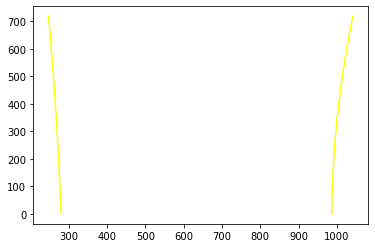

In [92]:
imgs = glob.glob('./test_images/*.jpg')
for i, img in enumerate(imgs):
    img = cv2.imread(img)
    dst_img = distortion_correction(img)
    sobel_x = abs_sobel_thresh(dst_img)
    s_segment = hls_select(dst_img)

    final_combination = np.zeros_like(s_segment)
    final_combination[(s_segment == 1) | (sobel_x == 1)] = 1
    warped, dst, src = warp(final_combination)
    
    warped, left_fitx, right_fitx = fit_polynomials(warped)
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    Minv = cv2.getPerspectiveTransform(dst, src) #To convert the wrapped image back to its original form
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    cv2.putText(result, 'Radius of curvature = {}m'.format(measure_curvature(warped)), (20,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)

    plt.imshow(out_img)
    plt.show()